# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.8 MB/s 
     |████████████████████████████████| 58 kB 2.0 MB/s 
     |████████████████████████████████| 376 kB 55.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=269e96d162276e9cd210e63d2debfb8dc2606f1749a8fd969de782585bd0639b
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0a238a21efe81c682601f3bf08f51cf46bc5d9400eb5c9c5cfadf732e7157ba9
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

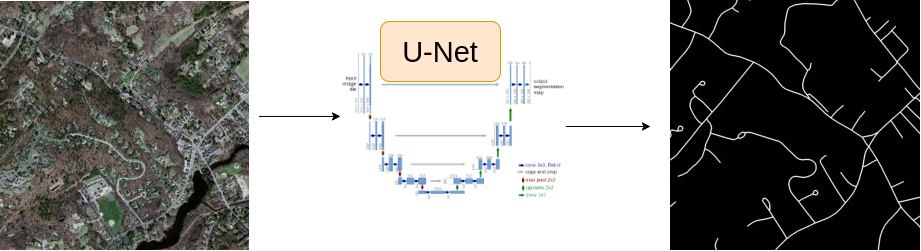

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 16.74 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = "/content/Road_seg_dataset/train.csv"
DATA_DIR = "/content/Road_seg_dataset/"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = "timm-efficientnet-b0"
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [7]:
idx = 15
row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

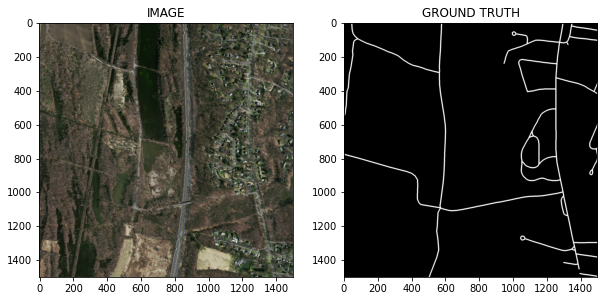

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

In [10]:
print(len(train_df))
print(len(valid_df))

159
40


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A 

In [12]:
def get_train_augs():
  return A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
  ])


# Task 4 : Create Custom Dataset 

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = df.iloc[idx] 

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)# (h, w, c)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)#(h,w)
    mask = np.expand_dims(mask, axis=-1) #(h, w, c)

    if self.augmentations:
      data = self.augmentations(image=image, mask = mask)
      image = data['image'] #(h, w, c)
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32) #(c,h,w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) #(c,h,w)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 159
Size of validset : 40


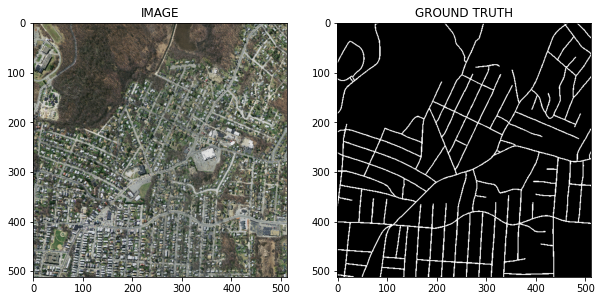

In [17]:
idx = 21

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True) 
validloader = DataLoader(validset, batch_size=BATCH_SIZE)


In [20]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 20
Total no. of batches in validloader : 5


In [21]:
for images, masks in trainloader:
  print(f"One batch image shape : {images.shape}")
  print(f"One batch mask shape : {masks.shape}")
  break

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn 

In [23]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks=None):
    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [24]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16

# Task 7 : Create Train and Validation Function 

In [25]:
def train_fn(dataloader, model, optimizer):
  model.train() # Turn ON dropout, batchnorm, etc.

  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss/ len(dataloader)


In [26]:
def eval_fn(dataloader, model):
  model.eval() # Turn ON dropout, batchnorm, etc.

  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss/ len(dataloader)

# Task 8 : Train Model

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [28]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("SAVED MODEL")
    best_loss = valid_loss

  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


SAVED MODEL
Epoch : 1 Train Loss : 1.2099445402622222 Valid Loss : 1.0288530707359314


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


SAVED MODEL
Epoch : 2 Train Loss : 0.7771218240261077 Valid Loss : 0.9495439767837525


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


SAVED MODEL
Epoch : 3 Train Loss : 0.6982391029596329 Valid Loss : 0.7561222195625306


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


SAVED MODEL
Epoch : 4 Train Loss : 0.675095596909523 Valid Loss : 0.6824399471282959


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch : 5 Train Loss : 0.6663842618465423 Valid Loss : 0.7015623927116394


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


SAVED MODEL
Epoch : 6 Train Loss : 0.6452785193920135 Valid Loss : 0.6207325696945191


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch : 7 Train Loss : 0.6390353500843048 Valid Loss : 0.637354850769043


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch : 8 Train Loss : 0.6241009145975113 Valid Loss : 0.6380379319190979


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


SAVED MODEL
Epoch : 9 Train Loss : 0.6160846501588821 Valid Loss : 0.6040308594703674


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


SAVED MODEL
Epoch : 10 Train Loss : 0.6177695989608765 Valid Loss : 0.5833082318305969


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch : 11 Train Loss : 0.5986798435449601 Valid Loss : 0.6229291439056397


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


SAVED MODEL
Epoch : 12 Train Loss : 0.6105967879295349 Valid Loss : 0.5807448565959931


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


SAVED MODEL
Epoch : 13 Train Loss : 0.6019999802112579 Valid Loss : 0.577405858039856


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch : 14 Train Loss : 0.6027420744299888 Valid Loss : 0.6061944663524628


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch : 15 Train Loss : 0.595786651968956 Valid Loss : 0.6029249012470246


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


SAVED MODEL
Epoch : 16 Train Loss : 0.5982294023036957 Valid Loss : 0.5658523678779602


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch : 17 Train Loss : 0.6058661669492722 Valid Loss : 0.5740333616733551


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch : 18 Train Loss : 0.5931341409683227 Valid Loss : 0.5700987040996551


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch : 19 Train Loss : 0.5940327167510986 Valid Loss : 0.5712218284606934


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch : 20 Train Loss : 0.5808314830064774 Valid Loss : 0.5709696769714355


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


SAVED MODEL
Epoch : 21 Train Loss : 0.5712894991040229 Valid Loss : 0.5526751577854156


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch : 22 Train Loss : 0.5678734347224236 Valid Loss : 0.5596546053886413


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch : 23 Train Loss : 0.5685994416475296 Valid Loss : 0.5618067860603333


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch : 24 Train Loss : 0.5695188403129577 Valid Loss : 0.6105310082435608


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

Epoch : 25 Train Loss : 0.5619326740503311 Valid Loss : 0.5807982683181763


# Task 9 : Inference

In [33]:
idx = 54

model.load_state_dict(torch.load("/content/best_model.pt"))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) -> (b, c, h, w)
pre_mask = torch.sigmoid(logits_mask)
pre_mask = (pre_mask > 0.5)*1.0

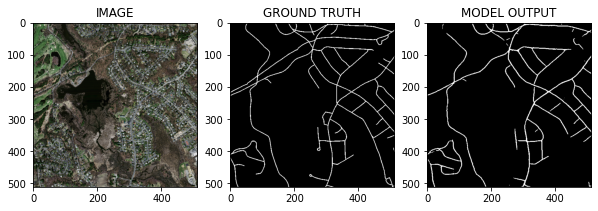

In [34]:
helper.show_image(image, mask, pre_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

